# PyTorchCV starter notebook [Train]

In [1]:
!nvidia-smi

Fri Sep 29 00:58:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
!pip install monai pydicom torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00a 0:00:01


## Setup and Imports

In [4]:
from glob import glob
import matplotlib.pyplot as plt
# from monai.utils import set_determinism
# import monai.transforms as monai_transforms
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm.notebook import tqdm as tqdm_nb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Configuration

In [5]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 20
    EPOCHS = 5
    TARGET_COLS = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]

config = Config()

## Reproducibility

In [6]:
random_seed = config.SEED
np.random.seed(random_seed)
set_determinism(random_seed)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
BASE_PATH = '/kaggle/input/rsna-atd-512x512-png-v2-dataset'

In [9]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

In [10]:
dataframe.head(5)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


In [11]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
valid_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, valid_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    valid_data = pd.concat([valid_data, valid_group], ignore_index=True)

In [12]:
train_data.shape, valid_data.shape

((9612, 21), (2417, 21))

## Data Pipeline /w dataloader

In [13]:
class RandomCutout(transforms.RandomApply):
    def __init__(self, p, cutout_height_factor=0.2, cutout_width_factor=0.2):
        cutout = transforms.RandomErasing(
            p=1.0, scale=(cutout_height_factor, cutout_width_factor), ratio=(1,1)
        )
        super(RandomCutout, self).__init__([cutout], p=p)

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, image_size, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = transforms.Resize(self.image_size)(image)
        image = transforms.ToTensor()(image)
        image = image / 255.0

        # split the labels
        labels = [
            label[0:1],  # bowel
            label[1:2],  # fluid
            label[2:5],  # kidney
            label[5:8],  # liver
            label[8:11], # spleen
        ]

        # for additional transformation
        if self.transform:
            image = self.transform(image)

        return image, labels

In [14]:
cutout_transform = RandomCutout(p=0.5, cutout_height_factor=0.2, cutout_width_factor=0.2)
transform = transforms.Compose([cutout_transform])

def build_dataset(image_paths, labels, batch_size, image_size, transform=transform):
    dataset = CustomDataset(image_paths, labels, image_size=image_size, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    return dataloader

## Build Model

In [15]:
class build_model(nn.Module):
    def __init__(
        self, num_classes_bowel,
        num_classes_extra, num_classes_liver,
        num_classes_kidney, num_classes_spleen
    ):
        super(build_model, self).__init__()
        
        # define backbone
        self.backbone = models.efficientnet_b5(pretrained=True)
        self.backbone._fc = nn.Identity()

        # delete 'necks' for each head
        self.neck_bowel = nn.Linear(1000, 32) # self.backbone._swish._num_features
        self.neck_extra = nn.Linear(1000, 32)
        self.neck_liver = nn.Linear(1000, 32)
        self.neck_kidney = nn.Linear(1000, 32)
        self.neck_spleen = nn.Linear(1000, 32)

        # define heads
        self.head_bowel = nn.Linear(32, num_classes_bowel)
        self.head_extra = nn.Linear(32, num_classes_extra)
        self.head_liver = nn.Linear(32, num_classes_liver)
        self.head_kidney = nn.Linear(32, num_classes_kidney)
        self.head_spleen = nn.Linear(32, num_classes_spleen)
    
    def forward(self, x):
        # forward pass through the backbone
        # print(x.shape)
        x = self.backbone(x)
        # print(x.shape)

        # forward pass through 'necks' and heads
        x_bowel = self.head_bowel(self.neck_bowel(x))
        x_extra = self.head_extra(self.neck_extra(x))
        x_liver = self.head_liver(self.neck_liver(x))
        x_kidney = self.head_kidney(self.neck_kidney(x))
        x_spleen = self.head_spleen(self.neck_spleen(x))

        return x_bowel, x_extra, x_liver, x_kidney, x_spleen

## Train the model

In [16]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths, train_labels = train_data.image_path.values, train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths, valid_labels = valid_data.image_path.values, valid_data[config.TARGET_COLS].values.astype(np.float32)

# train_paths = train_paths[:100]
# train_labels = train_labels[:100]
# valid_paths = valid_paths[:20]
# valid_labels = valid_labels[:20]


# train and valid dataset
train_ds = build_dataset(train_paths, train_labels, config.BATCH_SIZE, config.IMAGE_SIZE, transform)
valid_ds = build_dataset(valid_paths, valid_labels, config.BATCH_SIZE, config.IMAGE_SIZE, transform)

[INFO] Building the dataset...


In [17]:
# define the model
print("[INFO] Building the model...")
model = build_model(
    num_classes_bowel=1,
    num_classes_extra=1,
    num_classes_liver=3,
    num_classes_kidney=3,
    num_classes_spleen=3,
)
# load optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

[INFO] Building the model...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 164MB/s]  


In [21]:
# train
print("[INFO] Training...")

model = model.to(device)

values = list()

for epoch in tqdm_nb(range(1, config.EPOCHS+1)):
    # define loss functions
    criterion_bowel = nn.BCEWithLogitsLoss()
    criterion_extra = nn.BCEWithLogitsLoss()
    criterion_liver = nn.CrossEntropyLoss()
    criterion_kidney = nn.CrossEntropyLoss()
    criterion_spleen = nn.CrossEntropyLoss()

    # set the metrics
    tr_loss_bowel = MeanMetric().to(device)
    tr_loss_extra = MeanMetric().to(device)
    tr_loss_liver = MeanMetric().to(device)
    tr_loss_kidney = MeanMetric().to(device)
    tr_loss_spleen = MeanMetric().to(device)
    vl_loss_bowel = MeanMetric().to(device)
    vl_loss_extra = MeanMetric().to(device)
    vl_loss_liver = MeanMetric().to(device)
    vl_loss_kidney = MeanMetric().to(device)
    vl_loss_spleen = MeanMetric().to(device)
    
    tr_bacc_bowel = MulticlassAccuracy(num_classes=2, average="macro").to(device)
    tr_bacc_extra = MulticlassAccuracy(num_classes=2, average="macro").to(device)
    tr_bacc_liver = MulticlassAccuracy(num_classes=3, average="micro").to(device)
    tr_bacc_kidney = MulticlassAccuracy(num_classes=3, average="micro").to(device)
    tr_bacc_spleen = MulticlassAccuracy(num_classes=3, average="micro").to(device)
    vl_bacc_bowel = MulticlassAccuracy(num_classes=2, average="macro").to(device)
    vl_bacc_extra = MulticlassAccuracy(num_classes=2, average="macro").to(device)
    vl_bacc_liver = MulticlassAccuracy(num_classes=3, average="micro").to(device)
    vl_bacc_kidney = MulticlassAccuracy(num_classes=3, average="micro").to(device)
    vl_bacc_spleen = MulticlassAccuracy(num_classes=3, average="micro").to(device)
    
    # Train the model
    model.train()
    for image, label in tqdm_nb(train_ds):
        bowel, extra, liver, kidney, spleen = label
        true_bowel, true_extra, true_liver, true_kidney, true_spleen = bowel.to(device), extra.to(device), liver.to(device), kidney.to(device), spleen.to(device)
        inputs = image.to(device)
        
        pred_bowel, pred_extra, pred_liver, pred_kidney, pred_spleen = model(inputs)

        # compute the losses
        loss_bowel = criterion_bowel(pred_bowel, true_bowel)
        loss_extra = criterion_extra(pred_extra, true_extra)
        loss_liver = criterion_liver(pred_liver, true_liver)
        loss_kidney = criterion_kidney(pred_kidney, true_kidney)
        loss_spleen = criterion_spleen(pred_spleen, true_spleen)

        # compute total loss
        total_loss = loss_bowel + loss_extra + loss_liver + loss_kidney + loss_spleen

        # backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    # Save the model state
    state = model.state_dict()
    torch.save(state, f'model_{epoch}.pth')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for image, label in train_ds:
            bowel, extra, liver, kidney, spleen = label
            true_bowel, true_extra, true_liver, true_kidney, true_spleen = bowel.to(device), extra.to(device), liver.to(device), kidney.to(device), spleen.to(device)
            inputs = image.to(device)
            
            pred_bowel, pred_extra, pred_liver, pred_kidney, pred_spleen = model(inputs)

            # compute the losses
            loss_bowel = criterion_bowel(pred_bowel, true_bowel)
            loss_extra = criterion_extra(pred_extra, true_extra)
            loss_liver = criterion_liver(pred_liver, true_liver)
            loss_kidney = criterion_kidney(pred_kidney, true_kidney)
            loss_spleen = criterion_spleen(pred_spleen, true_spleen)

            tr_loss_bowel.update(loss_bowel.item())
            tr_loss_extra.update(loss_extra.item())
            tr_loss_liver.update(loss_liver.item())
            tr_loss_kidney.update(loss_kidney.item())
            tr_loss_spleen.update(loss_spleen.item())

            # compute the metrics
            pred_bowel, true_bowel = (pred_bowel>=0.5).float(), (true_bowel>=0.5).float()
            tr_bacc_bowel.update(pred_bowel, true_bowel)
            pred_extra, true_extra = (pred_bowel>=0.5).float(), (true_extra>=0.5).float()
            tr_bacc_extra.update(pred_extra, true_extra)
            pred_liver, true_liver = torch.argmax(pred_liver, dim=1), torch.argmax(true_liver, dim=1)
            tr_bacc_liver.update(pred_liver, true_liver)
            pred_kidney, true_kidney = torch.argmax(pred_kidney, dim=1), torch.argmax(true_kidney, dim=1)
            tr_bacc_kidney.update(pred_kidney, true_kidney)
            pred_spleen, true_spleen = torch.argmax(pred_spleen, dim=1), torch.argmax(true_spleen, dim=1)
            tr_bacc_spleen.update(pred_spleen, true_spleen)
            
        for image, label in valid_ds:
            bowel, extra, liver, kidney, spleen = label
            true_bowel, true_extra, true_liver, true_kidney, true_spleen = bowel.to(device), extra.to(device), liver.to(device), kidney.to(device), spleen.to(device)
            inputs = image.to(device)
            
            pred_bowel, pred_extra, pred_liver, pred_kidney, pred_spleen = model(inputs)
            
            # compute the losses
            loss_bowel = criterion_bowel(pred_bowel, true_bowel)
            loss_extra = criterion_extra(pred_extra, true_extra)
            loss_liver = criterion_liver(pred_liver, true_liver)
            loss_kidney = criterion_kidney(pred_kidney, true_kidney)
            loss_spleen = criterion_spleen(pred_spleen, true_spleen)

            vl_loss_bowel.update(loss_bowel.item())
            vl_loss_extra.update(loss_extra.item())
            vl_loss_liver.update(loss_liver.item())
            vl_loss_kidney.update(loss_kidney.item())
            vl_loss_spleen.update(loss_spleen.item())

            # compute the metrics
            pred_bowel, true_bowel = (pred_bowel>=0.5).float(), (true_bowel>=0.5).float()
            vl_bacc_bowel.update(pred_bowel, true_bowel)
            pred_extra, true_extra = (pred_bowel>=0.5).float(), (true_extra>=0.5).float()
            vl_bacc_extra.update(pred_extra, true_extra)
            pred_liver, true_liver = torch.argmax(pred_liver, dim=1), torch.argmax(true_liver, dim=1)
            vl_bacc_liver.update(pred_liver, true_liver)
            pred_kidney, true_kidney = torch.argmax(pred_kidney, dim=1), torch.argmax(true_kidney, dim=1)
            vl_bacc_kidney.update(pred_kidney, true_kidney)
            pred_spleen, true_spleen = torch.argmax(pred_spleen, dim=1), torch.argmax(true_spleen, dim=1)
            vl_bacc_spleen.update(pred_spleen, true_spleen)
            
    train_loss_bowel, valid_loss_bowel = tr_loss_bowel.compute(), vl_loss_bowel.compute()
    train_loss_extra, valid_loss_extra = tr_loss_extra.compute(), vl_loss_extra.compute()
    train_loss_liver, valid_loss_liver = tr_loss_liver.compute(), vl_loss_liver.compute()
    train_loss_kidney, valid_loss_kidney = tr_loss_kidney.compute(), vl_loss_kidney.compute()
    train_loss_spleen, valid_loss_spleen = tr_loss_spleen.compute(), vl_loss_spleen.compute()
    train_bacc_bowel, valid_bacc_bowel = tr_bacc_bowel.compute(), vl_bacc_bowel.compute()
    train_bacc_extra, valid_bacc_extra = tr_bacc_extra.compute(), vl_bacc_extra.compute()
    train_bacc_liver, valid_bacc_liver = tr_bacc_liver.compute(), vl_bacc_liver.compute()
    train_bacc_kidney, valid_bacc_kidney = tr_bacc_kidney.compute(), vl_bacc_kidney.compute()
    train_bacc_spleen, valid_bacc_spleen = tr_bacc_spleen.compute(), vl_bacc_spleen.compute()

    tr_bacc_bowel.reset(); tr_bacc_extra.reset(); tr_bacc_liver.reset(); tr_bacc_kidney.reset(); tr_bacc_spleen.reset()
    vl_bacc_bowel.reset(); vl_bacc_extra.reset(); vl_bacc_liver.reset(); vl_bacc_kidney.reset(); vl_bacc_spleen.reset()

    value = {
      'epoch': epoch,
      'train bowel loss': train_loss_bowel,
      'train extra loss': train_loss_extra,
      'train liver loss': train_loss_liver,
      'train kidney loss': train_loss_kidney,
      'train spleen loss': train_loss_spleen,
      'train bowel bacc': train_bacc_bowel,
      'train extra bacc': train_bacc_extra,
      'train liver bacc': train_bacc_liver,
      'train kidney bacc': train_bacc_kidney,
      'train spleen bacc': train_bacc_spleen,
      'valid bowel loss': valid_loss_bowel,
      'valid extra loss': valid_loss_extra,
      'valid liver loss': valid_loss_liver,
      'valid kidney loss': valid_loss_kidney,
      'valid spleen loss': valid_loss_spleen,
      'valid bowel bacc': valid_bacc_bowel,
      'valid extra bacc': valid_bacc_extra,
      'valid liver bacc': valid_bacc_bowel,
      'valid kidney bacc': valid_bacc_kidney,
      'valid spleen bacc': valid_bacc_spleen,
    }

    values.append(value)

[INFO] Training...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

## Visualize the training plots

In [23]:
values

[{'epoch': 1,
  'train bowel loss': tensor(0.0119, device='cuda:0'),
  'train extra loss': tensor(0.0030, device='cuda:0'),
  'train liver loss': tensor(0.0105, device='cuda:0'),
  'train kidney loss': tensor(0.0079, device='cuda:0'),
  'train spleen loss': tensor(0.0048, device='cuda:0'),
  'train bowel bacc': tensor(0.9952, device='cuda:0'),
  'train extra bacc': tensor(0.1553, device='cuda:0'),
  'train liver bacc': tensor(0.9964, device='cuda:0'),
  'train kidney bacc': tensor(0.9971, device='cuda:0'),
  'train spleen bacc': tensor(0.9983, device='cuda:0'),
  'valid bowel loss': tensor(0.0101, device='cuda:0'),
  'valid extra loss': tensor(0.0023, device='cuda:0'),
  'valid liver loss': tensor(0.0157, device='cuda:0'),
  'valid kidney loss': tensor(0.0116, device='cuda:0'),
  'valid spleen loss': tensor(0.0098, device='cuda:0'),
  'valid bowel bacc': tensor(0.9952, device='cuda:0'),
  'valid extra bacc': tensor(0.1553, device='cuda:0'),
  'valid liver bacc': tensor(0.9952, device='

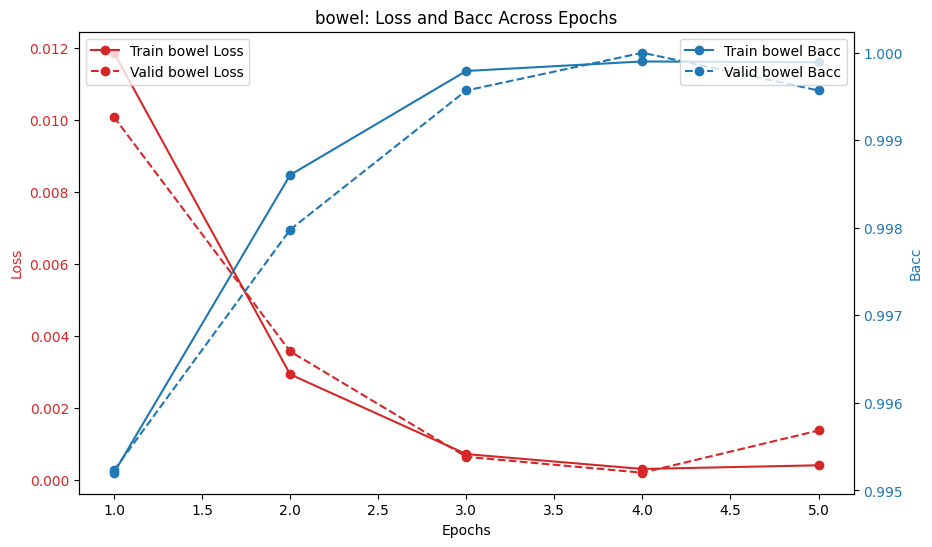

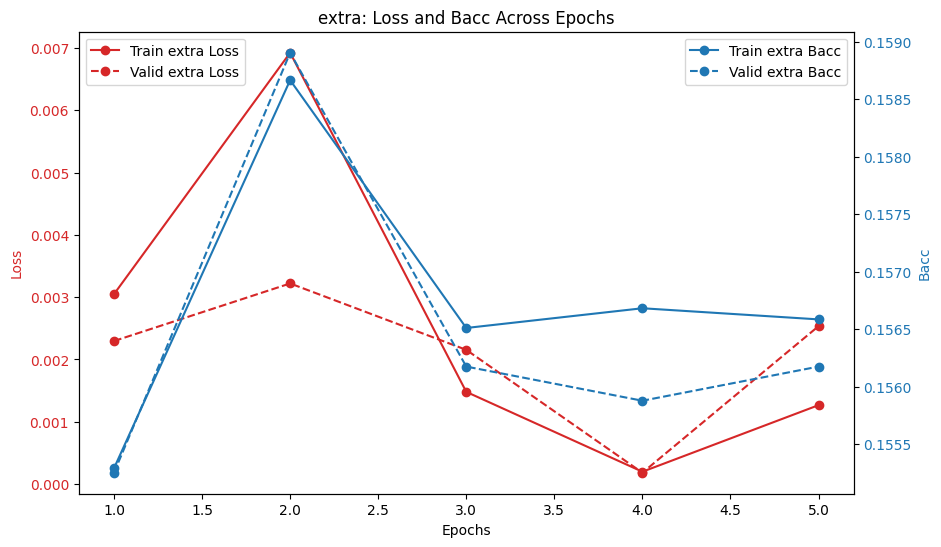

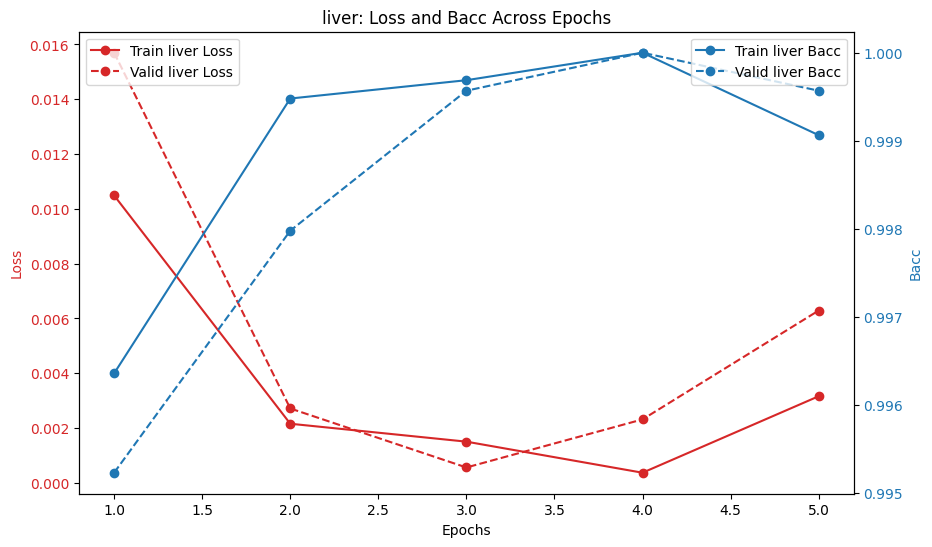

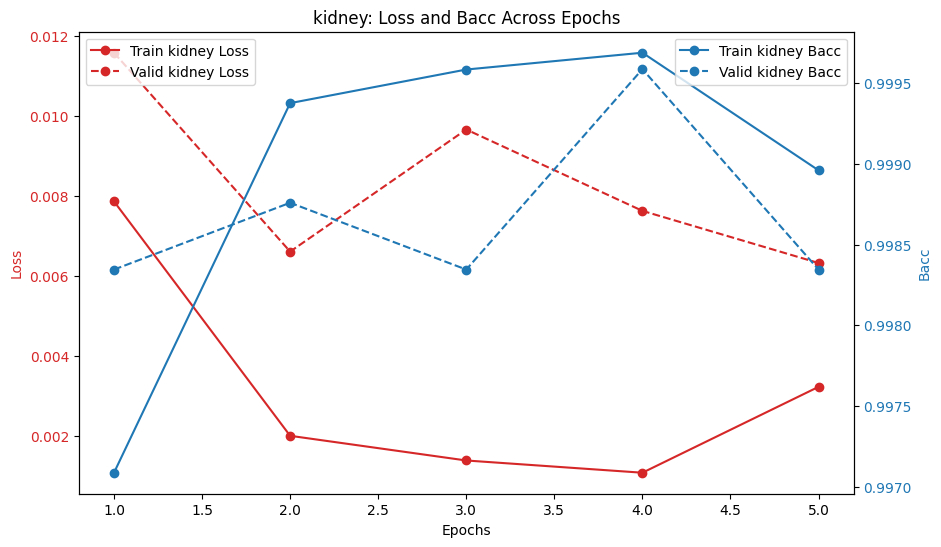

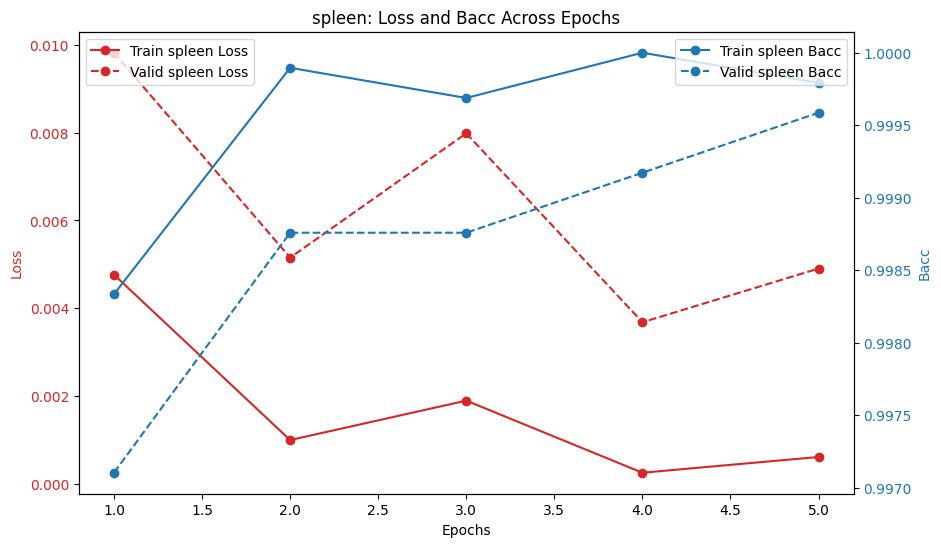

In [24]:
for name in ['bowel', 'extra', 'liver', 'kidney', 'spleen']:
    # extract data
    epochs = [entry['epoch'] for entry in values]
    train_loss = [entry[f'train {name} loss'].cpu().numpy() for entry in values]
    valid_loss = [entry[f'valid {name} loss'].cpu().numpy() for entry in values]
    train_bacc = [entry[f'train {name} bacc'].cpu().numpy() for entry in values]
    valid_bacc = [entry[f'valid {name} bacc'].cpu().numpy() for entry in values]
    
    # create subplots
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # plot loss values
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_loss, marker='o', label=f'Train {name} Loss', color='tab:red')
    ax1.plot(epochs, valid_loss, marker='o', label=f'Valid {name} Loss', linestyle='--', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # create a second y-axis for bacc values
    ax2 = ax1.twinx()
    ax2.set_ylabel('Bacc', color='tab:blue')
    ax2.plot(epochs, train_bacc, marker='o', label=f'Train {name} Bacc', color='tab:blue')
    ax2.plot(epochs, valid_bacc, marker='o', label=f'Valid {name} Bacc', linestyle='--', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # add legends
    ax1.legend(loc='upper left')  
    ax2.legend(loc='upper right')

    # set the title and labels
    plt.title(f'{name}: Loss and Bacc Across Epochs')
    plt.xlabel('Epochs')

    # show the plot
    plt.show()
    plt.close()